<a href="https://colab.research.google.com/github/lauragonzaga/MVP-Spotify-Hits-ML/blob/main/MVP_Spotify_Tracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MVP: Machine Learning & Analytics

**Aluna:** Laura Cardoso Gonzaga

**Matrícula:** 4052025001151

**Dataset:** [Spotify Music Dataset](https://www.kaggle.com/datasets/solomonameh/spotify-music-dataset)

# Descrição do Problema

## Contexto e objetivo

O objetivo do projeto é estimar a probabilidade de uma música alcançar alta popularidade no Spotify. Define-se "*hit*" como popularidade maior ou igual a 70 no atributo *"popularity"* associado a cada faixa.

O uso pretendido é auxiliar a tomada de decisão em áreas voltadas para o streaming musical, como marketing e curadoria. Na prática, o modelo pode ser aplicado na priorização de faixas para pitching e na alocação de recursos promocionais.

É importante ressaltar que o modelo tem limitações práticas. Fatores externos não contemplados nesse projeto podem influenciar fortemente o sucesso da faixa como por exemplo: a popularidade já consolidada do artista, o investimento na promoção da música, o funcionamento do algoritmo da plataforma e tendências culturais.

## Tipo de tarefa

O problema é de **aprendizado supervisionado**, pois existe uma variável-alvo (*is_hit*) que queremos prever a partir de features musicais e atributos categóricos. Dessa forma, trata-se de uma **classificação binária**, na qual cada faixa recebe rótulo 1 (“hit”) se sua popularidade >= 70, ou 0 (“não-hit”) caso contrário.

Além disso, é uma tarefa **probabilística**: o modelo não apenas prediz a classe, mas estima a probabilidade. Isso permite ranquear faixas por chance de sucesso e escolher diferentes thresholds de decisão conforme o custo relativo de falsos positivos e falsos negativos.

## Seleção de Dados

Foram utilizados dois arquivos públicos da mesma fonte  que posteriormente foram concatenados em um único conjunto de dados no notebook. Os dados foram extraídos usando a API do próprio Spotify usando dois scripts diferentes em Python — um para faixas populares e outro para faixas não tão populares.

Nesse dataset, as classes são desbalanceadas: cerca de 27% dos dados são da classe "hit". Isso afeta a escolha de métricas e será abordado na seção de modelagem.

## Atributos do Dataset
 <br>

### **Atributos Numéricos**

**Energy**: medida de intensidade e atividade da faixa.  

**Tempo**: medida em batidas por minuto (BPM).  

**Danceability**: índice que descreve o quão adequada a faixa é para dançar, baseado em tempo, estabilidade do ritmo, força da batida e regularidade geral.  

**Loudness**: volume médio geral da faixa em decibéis (dB). Valores mais altos indicam músicas mais altas.  

**Liveness**: probabilidade de a faixa ter sido performada ao vivo. Valores mais altos sugerem presença de audiência.  

**Valence**: medida de positividade musical de uma faixa. Valores altos indicam sons felizes; baixos, sons tristes ou raivosos.  

**Speechiness**: mede a presença de palavras faladas.  

**Instrumentalness**: probabilidade de a faixa não conter vocais. Valores próximos de 1.0 sugerem faixas totalmente instrumentais.  

**Mode**: indica a modalidade (maior ou menor) da faixa.  

**Key**: tonalidade musical, representada por um número inteiro de 0 a 11, mapeando para a notação padrão de classes de altura (pitch class).  

**Duration_ms**: duração da faixa em milissegundos.  

**Acousticness**: medida de confiança de que a faixa é acústica (1) ou não (0).  <br><br>

### **Atributos Categóricos**


**Track Name**: nome da faixa.  

**Track Artist**: artista(s) que performam a faixa.  

**Track Album Name**: nome do álbum em que a faixa está incluída.  

**Track Album Release Date**: data de lançamento do álbum que contém a faixa.  

**Track ID**: identificador único da faixa atribuído pelo Spotify.  

**Track Album ID**: identificador único do álbum.  

**Playlist Name**: nome da playlist em que a faixa está incluída.  

**Playlist Genre**: gênero principal associado à playlist.  

**Playlist Subgenre**: subgênero mais específico associado à playlist.

**Playlist ID**: identificador único da playlist.  

**Track Popularity**: pontuação (0–100) calculada com base no número total de streams em relação a outras músicas.  

# Reprodutibilidade

## Importação das Bibliotecas Necessárias


In [2]:
try:
    import pypalettes
except ImportError:
    !pip install -q pypalettes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 8.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pypalettes import load_cmap
import numpy as np
import random

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score,
                             roc_auc_score, average_precision_score,
                             classification_report, confusion_matrix,
                             PrecisionRecallDisplay)

import joblib, json, os, warnings
warnings.filterwarnings('ignore')

## Seeds fixas

Definir uma seed fixa é crucial para que os dados iniciais sejam sempre os mesmos e, assim, garantir a reprodutibilidade e comparação justa entre modelos.

In [4]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


## Carga de artefatos

Se existirem modelo final e CV salvos localmente, eles são carregados e o GridSearch é pulado, acelerando reexecuções na mesma sessão.

In [5]:
# === CARGA DE ARTEFATOS (local) ===
ARTIFACT_DIR = "."
MODEL_PATH   = os.path.join(ARTIFACT_DIR, "best_xgb.pkl")
GRID_PATH    = os.path.join(ARTIFACT_DIR, "grid_xgb.json")
CV_NUM_PATH  = os.path.join(ARTIFACT_DIR, "cv_num.pkl")
CV_FULL_PATH = os.path.join(ARTIFACT_DIR, "cv_full.pkl")

SKIP_GRID = False
cv_num, cv_full = None, None

# Modelo + Grid
if os.path.exists(MODEL_PATH):
    best_xgb = joblib.load(MODEL_PATH)
    SKIP_GRID = True
    print("Modelo final carregado do cache.")
    if os.path.exists(GRID_PATH):
        with open(GRID_PATH) as f:
            grid_summary = json.load(f)
        print("GridSearch (cache):", grid_summary)

# CV
if os.path.exists(CV_NUM_PATH) and os.path.exists(CV_FULL_PATH):
    try:
        cv_num  = joblib.load(CV_NUM_PATH)
        cv_full = joblib.load(CV_FULL_PATH)
        print("CV carregada do cache.")
    except Exception as e:
        print("Falha ao carregar CV do cache. Erro:", e)


# Carga de Dados

Importamos os dois csvs e concatenamos ambos em um único dataset.

In [6]:
# Lê dois subconjuntos (alta e baixa popularidade)
high = pd.read_csv("https://raw.githubusercontent.com/lauragonzaga/MVP-Machine-Learning/refs/heads/main/high_popularity_spotify_data.csv")
low = pd.read_csv("https://raw.githubusercontent.com/lauragonzaga/MVP-Machine-Learning/refs/heads/main/low_popularity_spotify_data.csv")

# # Concatena em um único dataset
df = pd.concat([high, low], ignore_index=True)


In [7]:
df.head()

,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,...,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,...,0.0000,10FLjwfpbxLmW8c25Xyc2N,0.0,6.0,251668.0,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4.0,0.0358,...,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1.0,2.0,210373.0,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4.0,0.0368,...,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1.0,1.0,166300.0,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4.0,0.0634,...,0.0000,4B4Elma4nNDUyl6D5PvQkj,0.0,0.0,157280.0,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,...,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0.0,0.0,169917.0,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M


# Pré-processamento

O pré-processamento é uma etapa essencial em qualquer projeto de Ciência de Dados, pois é nesse momento que os dados são preparados e organizados para as etapas de análise e modelagem.

### Remoção de dados duplicados

Para garantir consistência, removemos entradas duplicadas tomando como referência a coluna `track_id`, que é o identificador único de cada música.

In [8]:
df.duplicated(subset= 'track_id').sum()

np.int64(336)

In [9]:
df.drop_duplicates(subset= 'track_id', inplace=True)

### Tratamento de valores nulos

Foram eliminadas todas as linhas com valores ausentes para garantir que os modelos recebam apenas instâncias completas.

In [10]:
df.isna().sum().sort_values(ascending=False)

,0
energy,1
tempo,1
danceability,1
loudness,1
liveness,1
uri,1
valence,1
time_signature,1
speechiness,1
track_href,1


In [11]:
df.dropna(inplace=True)

## Remoção de variáveis

Removemos variáveis de identificação e metadados que não contribuem para a predição de popularidade e poderiam causar ruído ou vazamento de informação, sem agregar valor ao modelo.

In [12]:
drop_cols = [
    'track_id', 'id', 'track_album_id', 'uri',
    'track_href', 'analysis_url', 'type', 'playlist_id', 'playlist_name'
]

df.drop(columns=drop_cols, inplace = True)

## Renomeando colunas

Decidimos renomear alguns atributos para tornar os nomes mais simples e consistentes, facilitando a leitura do notebook e interpretação de resultados.

In [13]:
new_names = {
    'playlist_genre': 'genre',
    'track_artist': 'artist',
    'track_popularity': 'popularity',
    'track_album_name': 'album_name',
    'track_name': 'track',
    'track_album_release_date': 'release_date',
    'playlist_subgenre': 'subgenre'
}

df.rename(columns=new_names, inplace=True)

## Engenharia de atributos

*Feature engineering* consiste em criar, a partir dos atributos originais, um conjunto de atributos com informações relevantes. As etapas aplicadas nesse projeto correspondem à construção de recursos, pois criamos atributos derivados de colunas já existentes no dataset.

Primeiro, convertemos a duração em milissegundos para duração em minutos.


In [14]:
df["duration_min"] = df["duration_ms"] / 60000

Em seguida, criamos uma coluna para o ano de lançamento a partir da data completa.

In [15]:
df['release_year'] = df['release_date'].str[:4]

O atributo *release_year* foi usado apenas na EDA e não entrou na modelagem para evitar capturar viés de curadoria temporal.

## Variável target

Definimos a variável alvo *is_hit* como um indicador binário do sucesso da faixa. Consideramos como "hit" todas as músicas com `popularity` >= 70, atribuindo 1 para hits e 0 caso contrário.

In [16]:
df['is_hit'] = (df['popularity'] >= 70).astype(int)

In [17]:
df['is_hit'].value_counts(normalize=True)

,proportion
is_hit,
0,0.727131
1,0.272869


A distribuição da variável target se mostrou **desbalanceada**: aproximadamente 73% das músicas não são hits e apenas 27% são. Esse cenário é comum em problemas reais de classificação, no qual a classe positiva representa a minoria dos casos. Esse desbalanceamento impacta diretamente a escolha das métricas de avaliação e também a forma como o modelo é construído.

# Análise Exploratória de Dados

A etapa de Análise Exploratória de Dados (EDA) visa
entender a distribuição, relações e características das variáveis.


### Total e tipos de instâncias e colunas

In [18]:
print(f"Total de instâncias: {df.shape[0]}")
print(f"Total de colunas: {df.shape[1]}\n")

print(df.info())

Total de instâncias: 4493
Total de colunas: 23

<class 'pandas.core.frame.DataFrame'>
Index: 4493 entries, 0 to 4830
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   energy            4493 non-null   float64
 1   tempo             4493 non-null   float64
 2   danceability      4493 non-null   float64
 3   genre             4493 non-null   object 
 4   loudness          4493 non-null   float64
 5   liveness          4493 non-null   float64
 6   valence           4493 non-null   float64
 7   artist            4493 non-null   object 
 8   time_signature    4493 non-null   float64
 9   speechiness       4493 non-null   float64
 10  popularity        4493 non-null   int64  
 11  album_name        4493 non-null   object 
 12  track             4493 non-null   object 
 13  release_date      4493 non-null   object 
 14  instrumentalness  4493 non-null   float64
 15  mode              4493 non-null   float64
 16 

### Estatísticas descritivas

Estatísticas descritivas fornecem um resumo das características numéricas, incluindo média, desvio padrão, mínimo, máximo e quartis.

In [19]:
df.describe()

,energy,tempo,danceability,loudness,liveness,valence,time_signature,speechiness,popularity,instrumentalness,mode,key,duration_ms,acousticness,duration_min,is_hit
count,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4493.000000,4.493000e+03,4493.000000,4493.000000,4493.000000
mean,0.579408,118.277938,0.620474,-9.488965,0.167814,0.478716,3.936345,0.100426,53.284888,0.212226,0.564656,5.229245,2.055855e+05,0.351244,3.426425,0.272869
std,0.249897,28.708527,0.189483,7.287384,0.125195,0.259611,0.410730,0.100542,19.557342,0.359153,0.495857,3.574916,8.277526e+04,0.328896,1.379588,0.445484
min,0.000202,48.232000,0.058900,-48.069000,0.021000,0.029600,1.000000,0.021900,11.000000,0.000000,0.000000,0.000000,3.537500e+04,0.000004,0.589583,0.000000
25%,0.424000,96.029000,0.522000,-10.607000,0.095500,0.267000,4.000000,0.038400,39.000000,0.000000,0.000000,2.000000,1.582130e+05,0.056600,2.636883,0.000000
50%,0.627000,118.084000,0.653000,-7.301000,0.117000,0.480000,4.000000,0.055000,54.000000,0.000115,1.000000,5.000000,1.940430e+05,0.238000,3.234050,0.000000
75%,0.773000,137.092000,0.757000,-5.392000,0.195000,0.688000,4.000000,0.115000,70.000000,0.300000,1.000000,8.000000,2.329420e+05,0.615000,3.882367,1.000000
max,0.998000,241.426000,0.979000,1.318000,0.979000,0.987000,5.000000,0.927000,100.000000,0.991000,1.000000,11.000000,1.355260e+06,0.996000,22.587667,1.000000


`popularity`: tem média em torno de 53, mas forte assimetria; o valor do 3º quartil coincide exatamente com o threshold usado para definir hit (70), o que mostra que a classe positiva é minoria.

`energy`, `danceability`, `valence`: têm médias intermediárias, refletindo distribuição equilibrada entre faixas mais calmas e mais animadas.

`loudness`: varia bastante (de –48 dB a 1.3 dB)

`instrumentalness`: forte assimetria; a maioria das músicas tem valores próximos de 0, mas há algumas músicas instrumentais.

`duration`: tem mediana de ~3,2 minutos, consistente com o padrão de mercado, mas existem outliers de faixas muito longas.

`liveness` e `speechiness`: apresentam baixas medianas, sugerindo que a maior parte das músicas não é ao vivo nem centrada em fala.

## Parâmetros para visualizações



In [20]:
# Define a paleta de cores
cmap = load_cmap("Geyser")
discrete_palette = [cmap(i) for i in range(cmap.N)]
sns.set_palette(discrete_palette)

# Define parâmetros dos títulos
param_titulo = {'weight': 'bold', 'fontsize': 18, 'family': 'Liberation Sans'}
plt.rcParams['font.family'] = 'Liberation Sans'

plt.rcParams['figure.titlesize'] = 18

# Define estilo dos graficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style('darkgrid')

## Distribuição dos dados

Vamos verificar a distribuição de alguns atributos. Essa etapa nos permite visualizar padrões e se há necessidade de transformações nos dados.


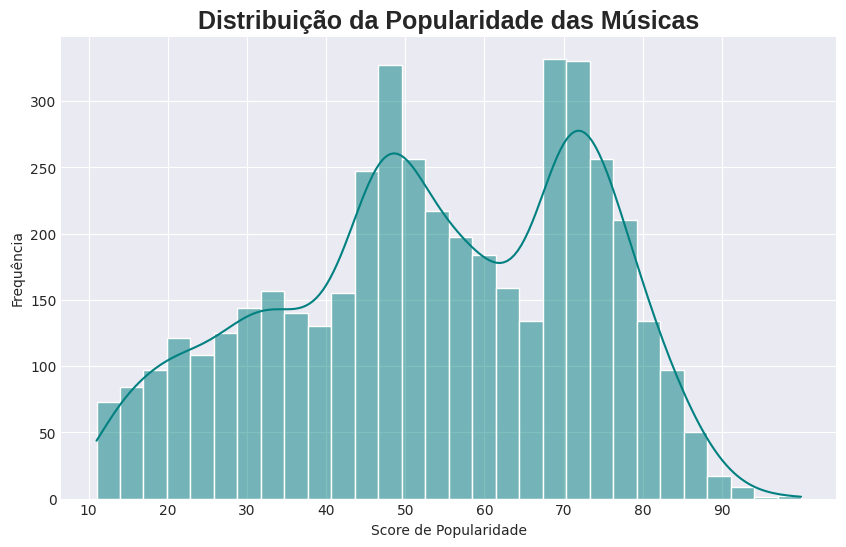

In [21]:
plt.figure(figsize=(10, 6))

sns.histplot(df['popularity'], bins=30, kde=True)

plt.title('Distribuição da Popularidade das Músicas',
          fontdict = param_titulo)
plt.xlabel('Score de Popularidade')
plt.ylabel('Frequência')
plt.xticks(range(10, 100, 10))
plt.show()

A distribuição de popularidade apresenta dois picos, um em torno de 50 e outro próximo a 70. Esse padrão sugere que existe uma concentração de músicas em faixas intermediárias de popularidade. Além disso, poucas faixas alcançam valores superiores a 80.

In [22]:
# Mediana da popularidade por gênero
genre_order_median = df.groupby("genre")["popularity"].median().sort_values(ascending=False).index

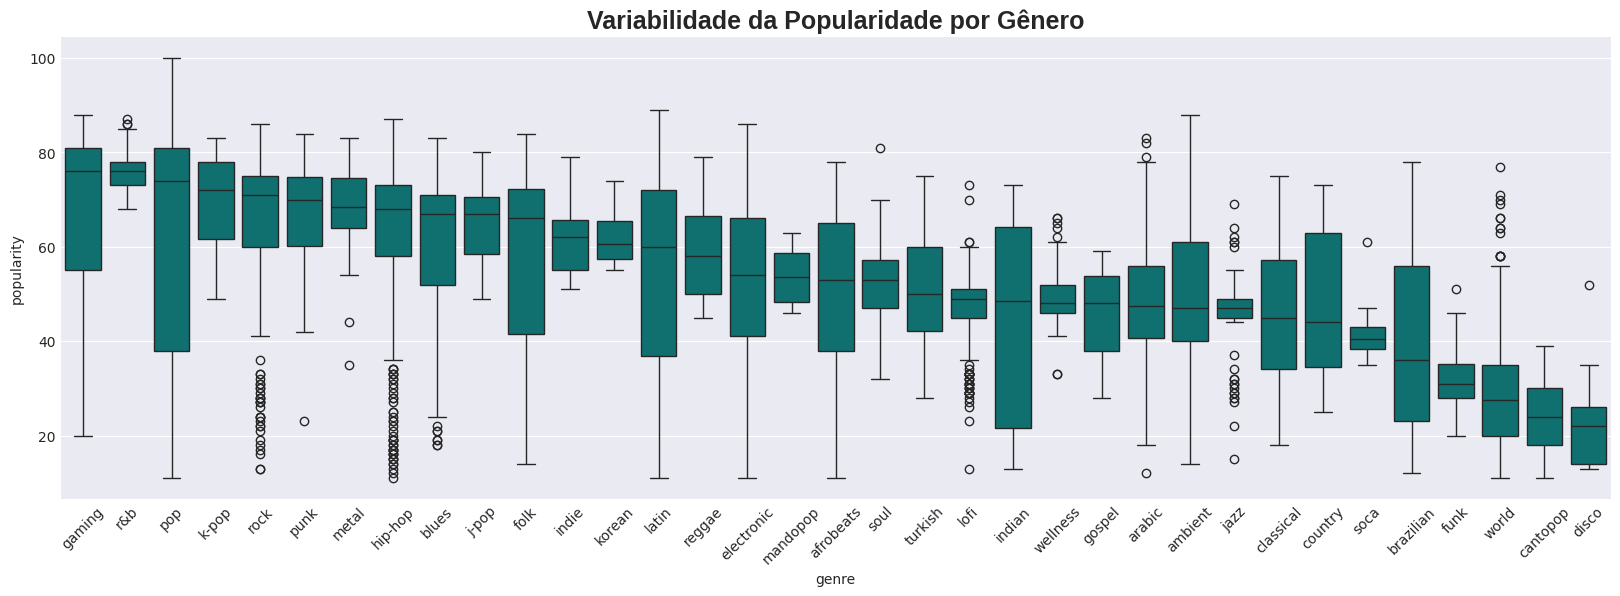

In [23]:
plt.figure(figsize=(20,6))

sns.boxplot(data=df,
            x="genre",
            y="popularity",
            order = genre_order_median)

plt.xticks(rotation=45)
plt.title("Variabilidade da Popularidade por Gênero",
          fontdict=param_titulo)
plt.show()

O boxplot revela a variabilidade da popularidade por gênero musical. Ordenamos as categorias pela mediana por ser uma estatística que reduz o impacto de outliers.

Os resultados mostram que gêneros como gaming, R&B e pop têm as maiores medianas, indicando que, de forma geral, as músicas nesses estilos alcançam níveis mais altos de popularidade.

Além disso, alguns gêneros revelam alta variabilidade interna (gaming, pop, folk), o que sugere que dentro de um mesmo estilo existem tanto músicas muito bem-sucedidas quanto faixas pouco conhecidas. Enquanto isso, algumas categorias como R&B se destacam pela concentração de popularidade em uma faixa pequena.



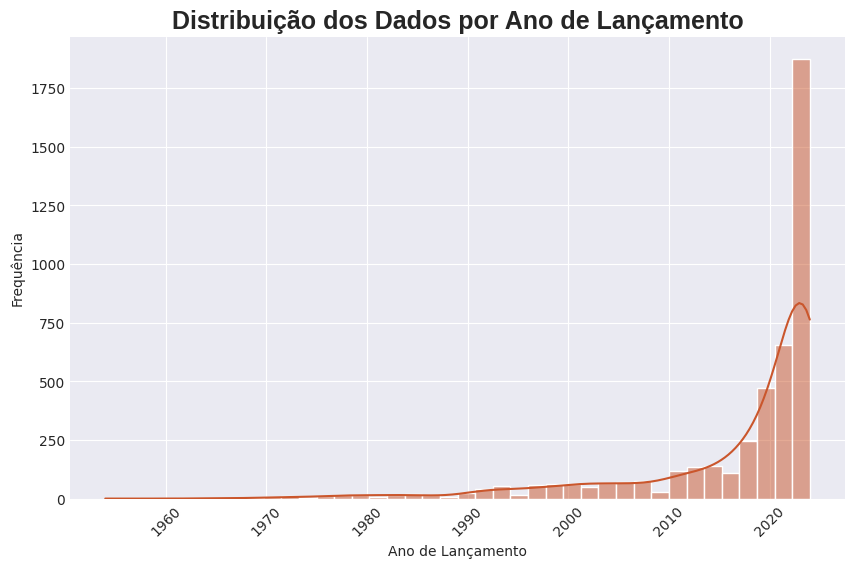

In [24]:
plt.figure(figsize=(10,6))

sns.histplot(df['release_year'].astype(int),
             bins=40,
             kde=True,
             color = cmap(6))

plt.title("Distribuição dos Dados por Ano de Lançamento", fontdict=param_titulo)
plt.xlabel("Ano de Lançamento")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.show()

In [25]:
df['release_year'].value_counts(normalize= True).head(5)

,proportion
release_year,
2024,0.262631
2023,0.154908
2022,0.085689
2021,0.059871
2020,0.059871


A base é fortemente concentrada em lançamentos recentes, especialmente após 2020, onde o volume de faixas cresce de forma exponencial. Grande parte das faixas está concentrada no ano de 2024 (26% aproximadamente). Isso significa que a amostra é dominada por músicas atuais, provavelmente porque foi extraída de playlists que priorizam músicas novas.

In [26]:
# Média de popularidade por ano

year_pop = df.groupby("release_year")["popularity"].mean()

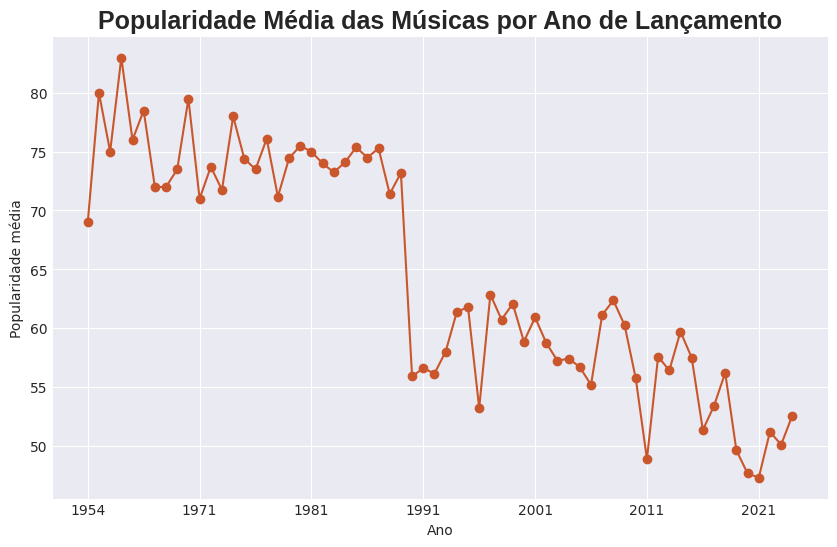

In [27]:
plt.figure(figsize=(10,6))

year_pop.plot(marker="o", color= cmap(6))

plt.title("Popularidade Média das Músicas por Ano de Lançamento", fontdict= param_titulo)
plt.xlabel("Ano")
plt.ylabel("Popularidade média")
plt.show()

A análise temporal revela que as músicas lançadas antes dos anos 1990 têm popularidade média bem mais alta. Esse padrão reflete claramente um **viés de curadoria**: as faixas mais antigas incluídas nesse dataset tendem a ser os grandes clássicos que chegaram em playlists justamente por se manterem relevantes até os dias atuais.

O desbalanceamento temporal aqui explicitado afeta a interpretação de tendências históricas e mostra que "ano de lançamento" não deve ser muito útil como variável explicativa.

## Matriz de correlação

In [28]:
features =  ["danceability","energy","loudness","speechiness",
             "acousticness","instrumentalness","liveness",
             "valence","tempo","duration_min","key","mode","time_signature"]


corr = df[features+["popularity"]].corr()

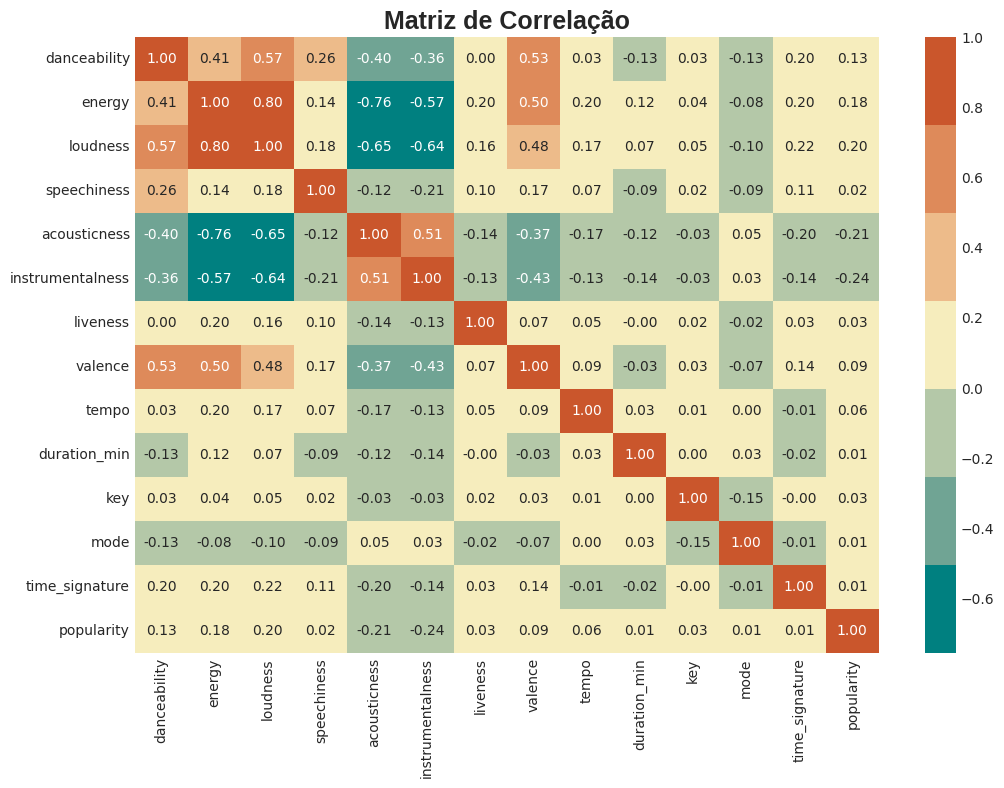

In [29]:
plt.figure(figsize=(12,8))

sns.heatmap(corr, annot=True, cmap= cmap, fmt=".2f")

plt.title("Matriz de Correlação",
          fontdict= param_titulo)
plt.show()

Podemos observar que as variáveis `loudness` e `energy` tem forte correlação positiva, ou seja, quanto maior a medida de energia da música, mais alta ela tende a ser em dB. Além disso, ambas têm correlação negativa com `acousticness` e `instrumentalness`.

Os atributos `duration_min`, `tempo`, `key`, `mode` e `time_signature` exibem correlação muito baixa com as demais, oferecendo pouca utilidade para o modelo.

As correlações com `popularity` são fracas, o que indica que relações lineares simples têm pouco poder explicativo.











## Scatterplots

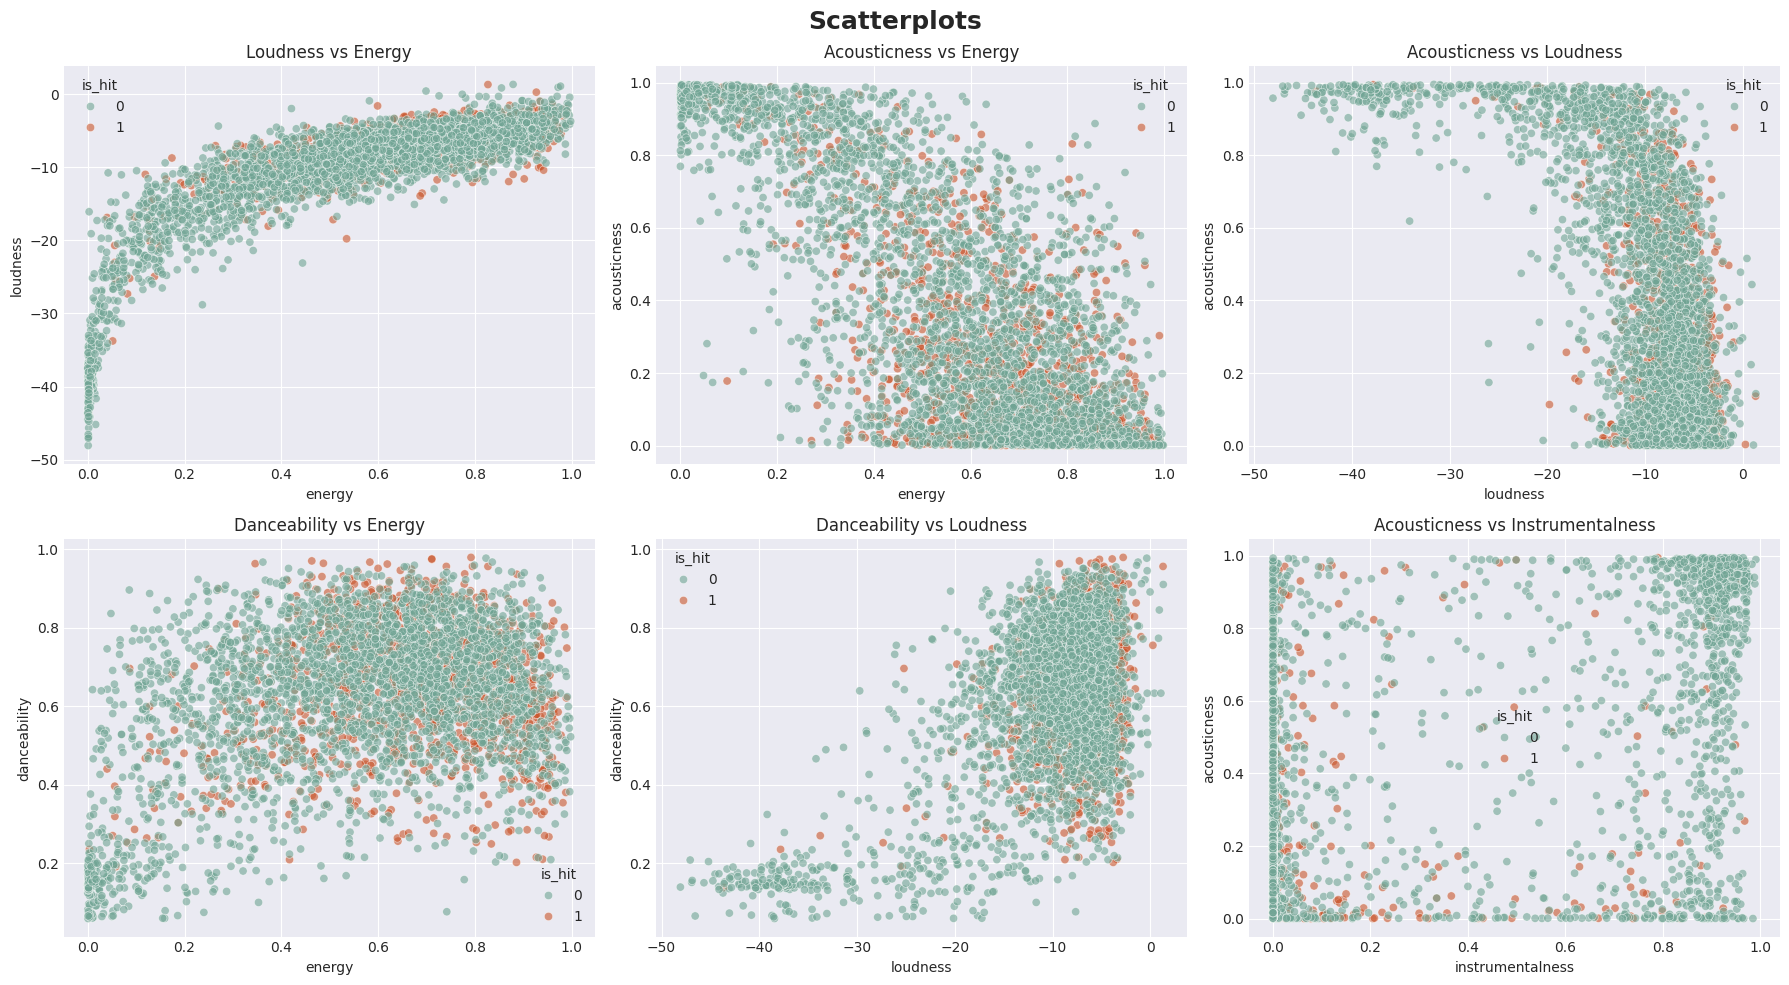

In [30]:
pairs = [
    ("energy", "loudness"),
    ("energy", "acousticness"),
    ("loudness", "acousticness"),
    ("energy", "danceability"),
    ("loudness", "danceability"),
    ("instrumentalness", "acousticness")

]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, (x, y) in zip(axes.flat, pairs):
    sns.scatterplot(
        data=df,
        x=x, y=y,
        hue="is_hit",
        palette=cmap([1,7]),
        alpha=0.6,
        ax=ax
    )
    ax.set_title(f"{y.capitalize()} vs {x.capitalize()}")


plt.suptitle("Scatterplots",
             fontweight = 550)
plt.tight_layout()
plt.show()


Os scatterplots confirmam padrões já esperados:

* `energy` e  `loudness` são fortemente correlacionados
* músicas mais acústicas tendem a ser menos energéticas e menos altas
* já `danceability` mostrou padrões menos definidos com `energy`, mas mostrou que valores baixos têm baixo `loudness`
* `instrumentalness` e `acousticness` não revelam padrão claro, indicando que músicas acústicas não são necessariamente instrumentais.

Além disso, não há separação visual clara entre hits e não-hits nesses pares de variáveis.

## Boxplots

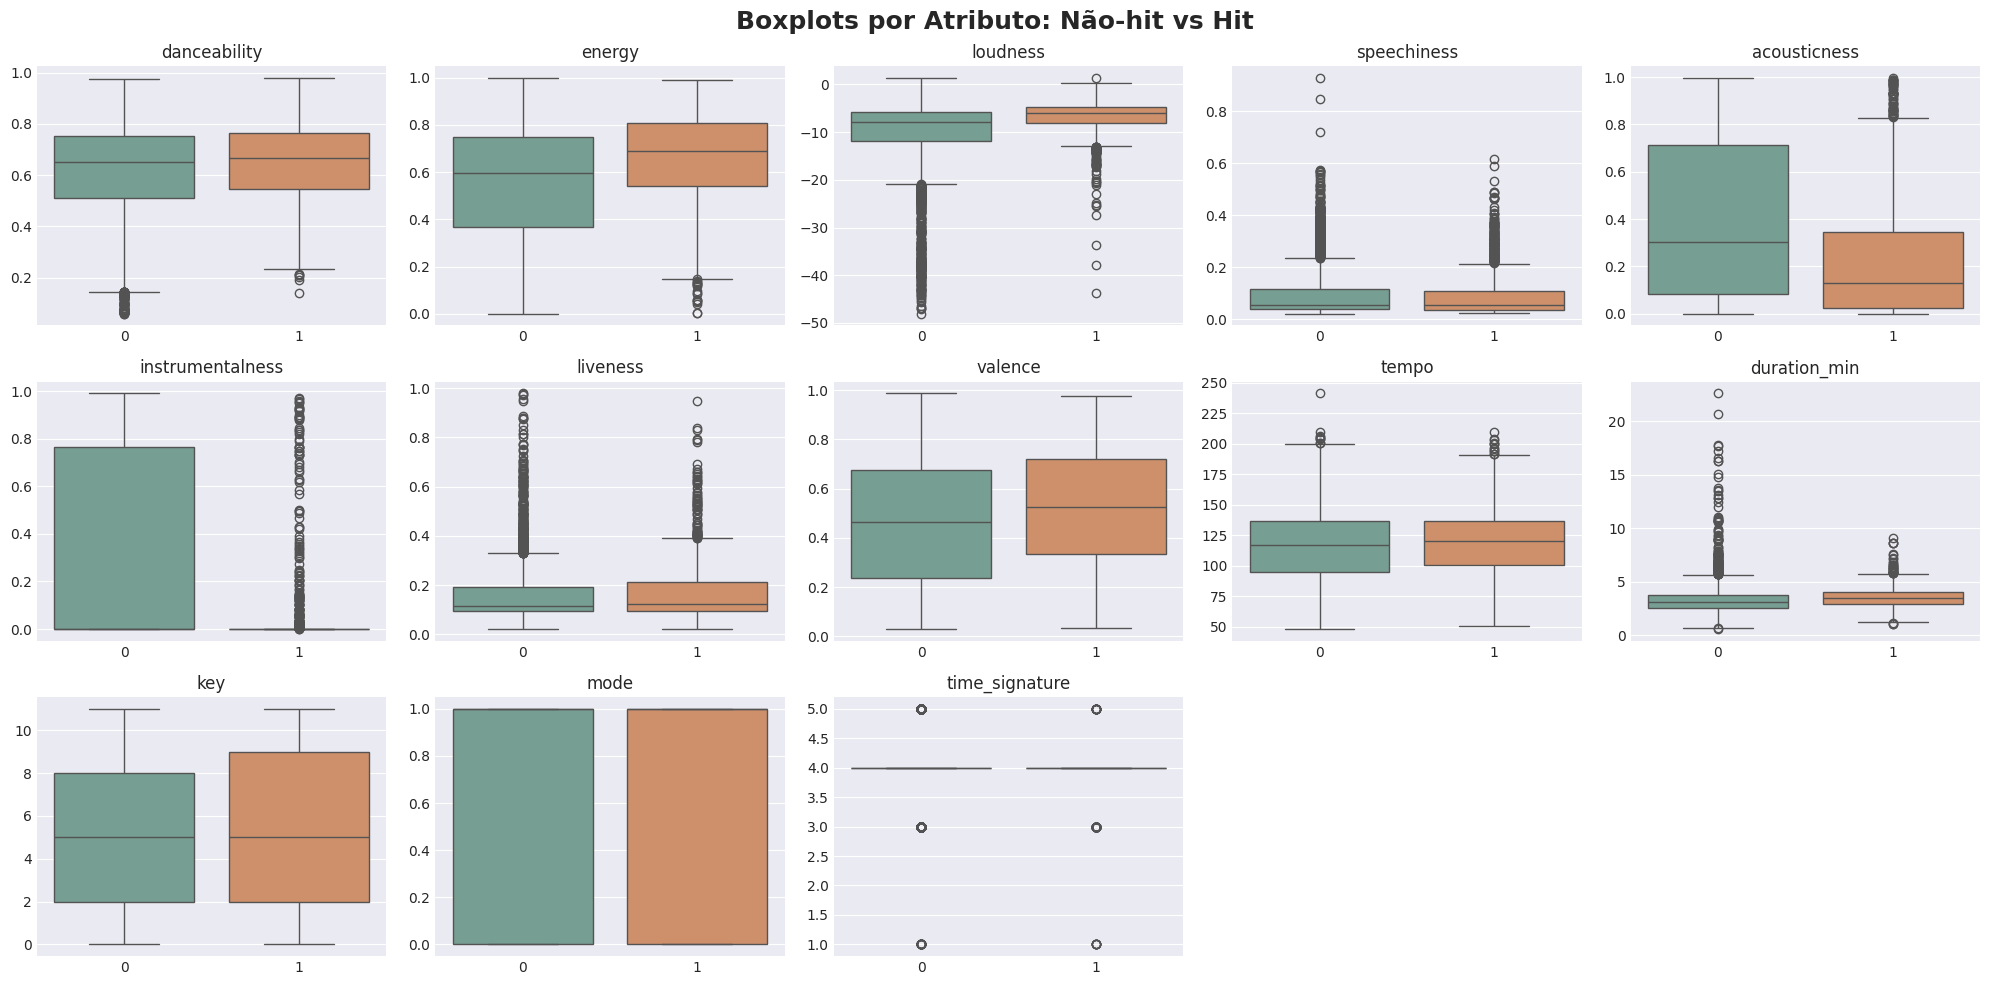

In [31]:
plt.figure(figsize=(20,10))

for i, col in enumerate(features, 1):
    plt.subplot(3,5,i)
    sns.boxplot(data=df, x="is_hit", y=col, palette= [cmap(1), cmap(5)])
    plt.title(f"{col}")
    plt.ylabel('')
    plt.xlabel('')

plt.suptitle("Boxplots por Atributo: Não-hit vs Hit",
             fontweight = 550)


plt.tight_layout()
plt.show()

Nos boxplots, hits se destacam por valores maiores de `energy`, `loudness`, `danceability` e `valence`, além de menores níveis de `acousticness` e `instrumentalness`. As demais variáveis praticamente não diferenciam as classes.

Com base nessa análise exploratória, podemos concluir que hits tendem a ser músicas dançáveis, energéticas, felizes, altas, menos acústicas e raramente instrumentais.

# Modelagem


## Divisão treino e teste

Decidimos trabalhar com duas matrizes de atributos:


*   X_num: contendo apenas variáveis numéricas
*   X_full: contendo as  mesmas variáveis numéricas acrescidas da variável categórica `genre`

Essa divisão serve para medir, em bases idênticas, o ganho preditivo de incluir o gênero musical e avaliar o risco de viés associado ao seu uso. O alvo é o mesmo em ambos os cenários.





In [32]:
features_num = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo', 'duration_min'
]

feature_cat = "genre"

target = "is_hit"

In [33]:
X_num = df[features_num].copy()
X_full = pd.concat([df[features_num], df[feature_cat]], axis=1)
Y = df[target].copy()

Realizamos divisão estratificada em treino e teste para cada X, garantindo a mesma proporção de classes em ambos os conjuntos. Usamos o mesmo random_state para que as partições sejam iguais e, assim, qualquer diferença de desempenho venha da inclusão da variável `genre`. O conjunto de teste é um hold-out único reservado para a avaliação final.

In [34]:
# splits estratificados (um para cada cenário)
X_train_num, X_test_num, Y_train, Y_test = train_test_split(
    X_num, Y, test_size=0.2, random_state=SEED, stratify=Y
)

X_train_f, X_test_f, Y_train_f, Y_test_f = train_test_split(
    X_full, Y, test_size=0.2, random_state=SEED, stratify=Y
)

In [35]:
print("Apenas variáveis numéricas -> Treino:", X_train_num.shape, "| Teste:", X_test_num.shape)
print("Numéricas + categórica     -> Treino:", X_train_f.shape, "| Teste:", X_test_f.shape)

Apenas variáveis numéricas -> Treino: (3594, 10) | Teste: (899, 10)
Numéricas + categórica     -> Treino: (3594, 11) | Teste: (899, 11)


## Baseline

Um baseline é um ponto de partida estabelecido para medir progresso de desempenho. Nesse caso, nosso baseline mínimo foi criado com *DummyClassifier* utilizando a estratégia *most_frequent*, que sempre prevê a classe mais frequente.  


In [36]:
baseline_dummy = {"Baseline": DummyClassifier(strategy="most_frequent", random_state=SEED)}

## Validação Cruzada

Criamos uma função (cv_table) que organiza a execução da validação cruzada estratificada k=5 com embaralhamento. Esse método recebe um dicionário de modelos, aplica a validação cruzada para cada um com métricas múltiplas (acurácia, F1, recall, ROC-AUC e PR-AUC) e retorna uma tabela com médias e desvios-padrão.

In [37]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [38]:
def cv_table(model_dict, X, y, name_col="Modelo"):
    rows = []
    scoring = {
        "acc": "accuracy",
        "f1": "f1",
        "rec": "recall",
        "roc": "roc_auc",
        "prauc": "average_precision",
    }
    for name, mdl in model_dict.items():
        cv = cross_validate(mdl, X, y, cv=skf, n_jobs=-1, scoring=scoring, return_train_score=False)
        rows.append([
            name,
            cv["test_acc"].mean(),  cv["test_acc"].std(),
            cv["test_f1"].mean(),   cv["test_f1"].std(),
            cv["test_rec"].mean(),  cv["test_rec"].std(),
            cv["test_roc"].mean(),  cv["test_roc"].std(),
            cv["test_prauc"].mean(),cv["test_prauc"].std()
        ])
    return pd.DataFrame(rows, columns=[
        name_col,
        "ACC_mean","ACC_std",
        "F1_mean","F1_std",
        "REC_mean","REC_std",
        "ROC_mean","ROC_std",
        "PR_mean","PR_std"
    ])

## Pipeline

Criação do fluxo de pré-processamento e modelagem em pipelines. Para atributos numéricos aplicamos **padronização** e para a variável categórica aplicamos **imputação simples** seguida de **one-hot encoding**. Esse encapsulamento evita vazamento de informação e garante reprodutibilidade.

Nos modelos LogReg e RandomForest, utilizamos *class_weight = "balanced"* para compensar o desbalanceamento penalizando erros na classe minoritária.

In [39]:
def criar_modelos(include_genre: bool):

  if include_genre:
    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), features_num),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")), # preenche nulos com a moda aprendida no treino
                ("oh", OneHotEncoder(handle_unknown="ignore")) # ignora categorias inéditas não vistas no treino
            ]), [feature_cat])
        ]
    )
  else:
    preprocess = ColumnTransformer([("num", StandardScaler(), features_num)],
                                   remainder="drop") # só entra o que foi declarado (anti-vazamento)

  modelos = {
        "LogReg": Pipeline([
            ("prep", preprocess),
            ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED))
        ]),
        "RF": Pipeline([
            ("prep", preprocess),
            ("clf", RandomForestClassifier(n_estimators=300, random_state=SEED, class_weight="balanced"))
        ]),
        "XGB": Pipeline([
            ("prep", preprocess),
            ("clf", XGBClassifier(
                n_estimators=400, learning_rate=0.08, max_depth=5,
                subsample=0.9, colsample_bytree=0.9, random_state=SEED))
        ])
    }
  return modelos

## Treino por validação cruzada

Comparação entre modelos no conjunto de treino usando a validação cruzada estratificada k=5.

A métrica principal de comparação é a PR-AUC, que é a mais adequada em casos de desbalanceamento de classes porque resume o *trade-off* entre *precision* (penaliza falsos positivos) e *recall* (penaliza falsos negativos). Essa métrica foca especificamente no desempenho do modelo na classe minoritária, o que facilita enxergar ganho real em cenários desbalanceados.

In [40]:
modelos_num = criar_modelos(include_genre=False)
modelos_full = criar_modelos(include_genre=True)

In [41]:
# === Carrega do cache se existir. Caso contrário, calcula e salva ===

if cv_num is None or cv_full is None:
    cv_num  = cv_table(modelos_num,  X_train_num, Y_train,   name_col="Modelo")
    cv_full = cv_table(modelos_full, X_train_f,   Y_train_f, name_col="Modelo")
    joblib.dump(cv_num,  CV_NUM_PATH)
    joblib.dump(cv_full, CV_FULL_PATH)

else:
    print("CV reutilizada do cache.")

In [42]:
print("\n=== CV (só variáveis numéricas) ===")
print(cv_num.round(3))

print("\n=== CV (completo) ===")
print(cv_full.round(3))


=== CV (só variáveis numéricas) ===
   Modelo  ACC_mean  ACC_std  F1_mean  F1_std  REC_mean  REC_std  ROC_mean  \
0  LogReg     0.587    0.011    0.518   0.014     0.811    0.033     0.709   
1      RF     0.739    0.009    0.296   0.014     0.201    0.011     0.744   
2     XGB     0.733    0.010    0.407   0.023     0.336    0.021     0.737   

   ROC_std  PR_mean  PR_std  
0    0.014    0.424   0.017  
1    0.021    0.490   0.022  
2    0.018    0.479   0.011  

=== CV (completo) ===
   Modelo  ACC_mean  ACC_std  F1_mean  F1_std  REC_mean  REC_std  ROC_mean  \
0  LogReg     0.742    0.013    0.633   0.013     0.816    0.015     0.839   
1      RF     0.800    0.008    0.538   0.019     0.426    0.019     0.856   
2     XGB     0.801    0.010    0.589   0.023     0.523    0.034     0.845   

   ROC_std  PR_mean  PR_std  
0    0.014    0.655   0.027  
1    0.017    0.691   0.018  
2    0.017    0.678   0.024  


Nos dados só numéricos, os modelos RF e XGB superam a LogReg em PR-AUC, sinal de que há não linearidades/interações úteis entre as features musicais.

Ao incluir `genre`, todas as métricas sobem de forma consistente. PR-AUC vai para 0,655 (LogReg), 0,691 (RF) e 0,678 (XGB) e o desvio-padrão é baixo, mostrando que esta variável carrega valor preditivo forte.

Logistic Regression se destaca pelo recall muito elevado (~0,82), ou seja, consegue capturar a maior parte dos hits mesmo ao custo de menor precisão.

## Avaliação no teste

Após escolher os modelos pela CV, cada pipeline foi re-treinado em todo o conjunto de treino e então avaliado uma única vez no conjunto de teste. Reportamos uma tabela consolidada comparando três cenários: baseline Dummy, modelos só com variáveis numéricas (X_num) e modelos com a categórica genre adicionada (X_full). Para converter probabilidades em rótulos usamos threshold = 0,5.

In [43]:
def avalia_no_teste(modelos, Xtr, ytr, Xte, yte, threshold=0.5):
    rows = []
    for nome, mdl in modelos.items():
        m = clone(mdl).fit(Xtr, ytr) # clone garante treino independente por cenário
        proba = m.predict_proba(Xte)[:,1]
        pred  = (proba >= threshold).astype(int)
        rows.append([
            nome,
            accuracy_score(yte, pred),
            precision_score(yte, pred, zero_division=0),
            recall_score(yte, pred, zero_division=0),
            f1_score(yte, pred, zero_division=0),
            roc_auc_score(yte, proba),
            average_precision_score(yte, proba)
        ])
    return pd.DataFrame(rows, columns=["Modelo","ACC","PREC","REC","F1","ROC_AUC","PR_AUC"])

In [44]:
res_base = avalia_no_teste(baseline_dummy, X_train_num, Y_train, X_test_num, Y_test)
res_num  = avalia_no_teste(modelos_num,  X_train_num, Y_train, X_test_num, Y_test)
res_full = avalia_no_teste(modelos_full, X_train_f, Y_train_f, X_test_f, Y_test_f)

In [45]:
metrics_test = pd.concat([
    res_base.assign(Cenário="Baseline"),
    res_num.assign(Cenário="Num"),
    res_full.assign(Cenário="Full")
], ignore_index=True).sort_values("PR_AUC", ascending = False) #ordena pela métrica de decisão

In [46]:
print("Métricas no Teste:")
print(metrics_test.round(3))

Métricas no Teste:
     Modelo    ACC   PREC    REC     F1  ROC_AUC  PR_AUC   Cenário
6       XGB  0.799  0.667  0.522  0.586    0.859   0.695      Full
5        RF  0.791  0.697  0.412  0.518    0.854   0.669      Full
4    LogReg  0.746  0.522  0.837  0.643    0.840   0.630      Full
3       XGB  0.742  0.550  0.290  0.380    0.732   0.487       Num
2        RF  0.739  0.566  0.176  0.268    0.727   0.462       Num
1    LogReg  0.587  0.379  0.808  0.516    0.696   0.409       Num
0  Baseline  0.727  0.000  0.000  0.000    0.500   0.273  Baseline


O baseline Dummy tem como piso a prevalência. Logo, tem acurácia alta (0,727) por causa da classe majoritária, mas F1=0 e PR-AUC=0,273, evidenciando que acurácia é enganosa em casos de desbalanceamento.

Nos resultados, o modelo **XGB** com **X_full** foi o melhor em termos de PR-AUC, sendo portanto escolhido como modelo final para priorização de faixas em estratégias de marketing e curadoria.

Entretanto, vale observar que a Logistic Regression apresentou recall substancialmente maior (~0,84 no teste). Em cenários de negócio onde o custo de perder um possível hit (falsos negativos) é mais relevante que o custo de promover músicas que possivelmente não terão sucesso, uma política *recall-first* poderia levar à escolha da LogReg como modelo preferencial.

## PR-AUC

Traçamos a curva Precision–Recall no teste para os mesmos modelos.

In [47]:
fitted = {}
scores  = {}

for name, pipe in modelos_full.items():
    mdl = clone(pipe)
    mdl.fit(X_train_f, Y_train_f)
    y_score = mdl.predict_proba(X_test_f)[:, 1] # curvas PR utilizam probabilidades e não rótulos
    scores[name] = y_score
    fitted[name] = mdl

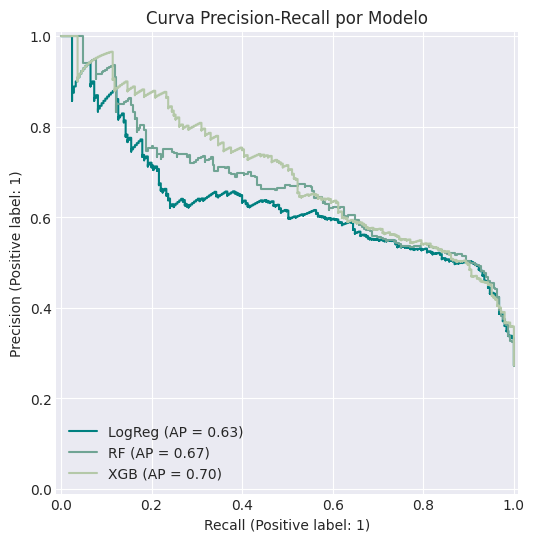

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

for name, y_score in scores.items():
    PrecisionRecallDisplay.from_predictions(Y_test_f, y_score, ax=ax, name=name)


plt.title("Curva Precision-Recall por Modelo")
plt.show()

Ao longo dos thresholds, o modelo XGBoost mantém a melhor combinação entre precisão e recall. A curva mostra que thresholds mais baixos aumentam recall mas reduzem precisão, e vice-versa.

## Grid Search

O GridSearchCV é um método que permite buscar automaticamente a melhor configuração de hiperparâmetros de um modelo. Ele testa, de forma sistemática, todas as combinações possíveis dentro de uma grade pré-definida, avalia cada uma por validação cruzada e, ao final, armazena o resultado no próprio objeto, incluindo qual conjunto de parâmetros apresentou o melhor desempenho.

Aqui, o espaço de busca inclui: número de árvores, profundidade, taxa de aprendizado e amostragens de colunas e linhas. O melhor conjunto de hiperparâmetros foi então reajustado em todo o treino e avaliado no teste.

In [49]:
xgb_pipe = modelos_full["XGB"]

param_grid = {
    "clf__n_estimators": [300, 500],
    "clf__max_depth": [4, 5, 6],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.8, 0.9, 1.0]
}

No Colab (CPU), o GridSearch do XGB leva cerca de 4 minutos na primeira execução. Reexecuções reutilizam artefatos e pulam o GridSearch.

In [50]:
# === GRID SEARCH (pula se já existe modelo salvo) ===
if not SKIP_GRID:
    gs = GridSearchCV(xgb_pipe, param_grid, scoring="average_precision", cv=5, n_jobs=-1)
    gs.fit(X_train_f, Y_train_f)
    print("Best params:", gs.best_params_)
    print("Best CV PR-AUC:", round(gs.best_score_, 4))

    best_xgb = gs.best_estimator_

    joblib.dump(best_xgb, MODEL_PATH)
    with open(GRID_PATH, "w") as f:
        json.dump({"best_params": gs.best_params_,
                   "best_score": float(gs.best_score_)}, f)
    print("Modelo final e resumo do Grid salvos.")
else:
    print("Pulando GridSearch (modelo em cache).")


Best params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 300, 'clf__subsample': 0.9}
Best CV PR-AUC: 0.6952
Modelo final e resumo do Grid salvos.


In [117]:
# Avaliação final no teste com melhores params
y_proba = best_xgb.predict_proba(X_test_f)[:,1]
y_pred  = (y_proba >= 0.5).astype(int)

print("TESTE: XGB")
print("ACC:", round(accuracy_score(Y_test_f, y_pred), 3),
      "| F1:", round(f1_score(Y_test_f, y_pred), 3),
      "| REC:", round(recall_score(Y_test_f, y_pred), 3),
      "| PREC:", round(precision_score(Y_test_f, y_pred), 3),
      "| ROC-AUC:", round(roc_auc_score(Y_test_f, y_proba), 3),
      "| PR-AUC:", round(average_precision_score(Y_test_f, y_proba), 3))

TESTE: XGB
ACC: 0.8 | F1: 0.567 | REC: 0.482 | PREC: 0.69 | ROC-AUC: 0.864 | PR-AUC: 0.7


## Avaliação final

In [118]:
print("Relatório de classificação (teste):\n")
print(classification_report(Y_test_f, y_pred, digits=3))

Relatório de classificação (teste):

              precision    recall  f1-score   support

           0      0.826     0.919     0.870       654
           1      0.690     0.482     0.567       245

    accuracy                          0.800       899
   macro avg      0.758     0.700     0.719       899
weighted avg      0.789     0.800     0.787       899



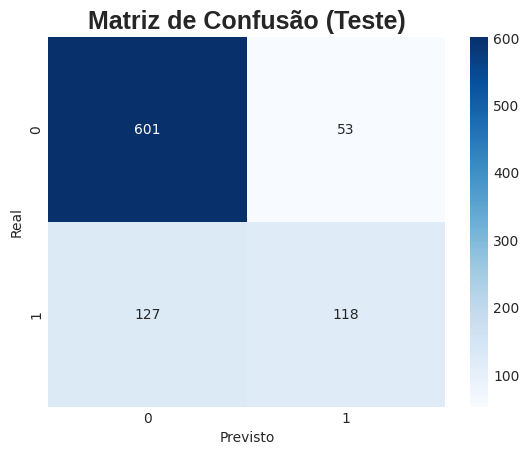

In [130]:
cm = confusion_matrix(Y_test_f, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão (Teste)", fontdict=param_titulo)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

Esse resultado evidencia o comportamento mais conservador do modelo: alta taxa de acerto nos não-hits, mas recall limitado nos hits. Isso reforça a necessidade de ajustar o *threshold* ou operar por ranking para capturar mais hits, se essa for a prioridade de negócio.

## Utilizando o modelo

Aqui temos um exemplo de uso do modelo final para ranquear as faixas por probabilidade de sucesso.

In [101]:
ranking_faixas = df.loc[X_test_f.index, ["track","artist", "genre", "popularity"]].copy()
ranking_faixas["is_hit"] = Y_test_f.values
ranking_faixas["proba_hit"] = y_proba

ranking_faixas = ranking_faixas.sort_values("proba_hit", ascending=False)

# Mostra as top-10
ranking_faixas.head(10)

,track,artist,genre,popularity,is_hit,proba_hit
496,on one tonight,Gunna,gaming,82,1,0.964805
488,fukumean,Gunna,gaming,82,1,0.950750
539,Boyz In Paris (with VINAI),"Marnik, Naeleck, VINAI",gaming,75,1,0.949796
532,ONE CALL,Rich Amiri,gaming,76,1,0.949012
526,TUCA DONKA,"CURSEDEVIL, DJ FKU, Skorde",gaming,77,1,0.946331
460,FE!N (feat. Playboi Carti),"Travis Scott, Playboi Carti",gaming,88,1,0.942147
479,one of wun,Gunna,gaming,84,1,0.941134
389,The Weekend,SZA,r&b,73,1,0.934071
355,Best Time,Brent Faiyaz,r&b,80,1,0.931813
392,Confessions Part II,USHER,r&b,68,0,0.929536


# Conclusões, limitações e próximos passos

#### **Conclusão**
O trabalho cumpriu o objetivo de aplicar técnicas de aprendizado supervisionado para prever a probabilidade de uma música atingir alta popularidade no Spotify. A análise exploratória identificou variáveis-chave relacionadas ao sucesso, como *energy, loudness, danceability, valence* e *acousticness*, além da forte contribuição do atributo categórico *genre*.

Entre os modelos avaliados, o **XGB** com inclusão de gênero apresentou o melhor desempenho em termos de PR-AUC, sendo escolhido como modelo ideal para priorização de faixas em estratégias de marketing e curadoria. Ainda assim, destacamos que a **Logistic Regression** apresentou recall mais elevado, o que poderia torná-la preferível em situações em que o custo de perder um hit é maior que o de promover um não-hit.  <br><br>

#### **Limitações**
O dataset é proveniente de playlists do Spotify, o que introduz viés de curadoria. Nessa seleção, músicas antigas são geralmente clássicos com popularidade consolidada, enquanto o grande volume de lançamentos recentes inclui muitas faixas de baixa popularidade.

Além disso, a variável de popularidade é influenciada por fatores externos não modelados aqui, como investimento em marketing, algoritmos de recomendação da plataforma e tendências culturais.<br><br>



#### **Próximos passos**

Alguns possíveis aprimoramentos seriam:

* Ajustar o threshold de decisão.

* Testar modelos adicionais ou ensembles.

* Usar datasets maiores e com menor desbalanceamento.

* Explorar dados externos de artistas e campanhas de promoção, enriquecendo a base.